# Generate Anchors for YOLOv3
Anchor sizes for YOLOv3 are defined based on object sizes in MS COCO dataset.
 On the COCO dataset the 9 clusters were:
- Small objects: (10×13),(16×30),(33×23)
- Medium objects: (30×61),(62×45),(59×119)
- Large objects: (116 × 90),(156 × 198),(373 × 326)
These sizes are relevant to an input size of 416 x 416.

Blood cells are circular and the object sizes (i.e size of RBC , WBC or Platelets) likely to differ from natural objects observed in MS COCO dataset.
This notebook is set up to derive new proposal anchors relevant to BCCD dataset.

In [1]:
# Import all libraries here
import numpy as np
import pandas as pd

import util
import glob

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# Extract data from zip file
!unzip '/content/BCCD_New.zip'

In [3]:
# store annotations in a data frame
BCCDdf,_ = util.load_data(annotation_path='/content/Annotations')

In [4]:
BCCDdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7394 entries, 3599 to 3696
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         7394 non-null   int64 
 1   filename   7394 non-null   object
 2   cell_type  7394 non-null   object
 3   xmin       7394 non-null   int64 
 4   xmax       7394 non-null   int64 
 5   ymin       7394 non-null   int64 
 6   ymax       7394 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 462.1+ KB


ID: Image ID  
filename: Location of the image file for respective annotation
cell_type: Label (RBC/WBC/Platelet)  
(xmin,ymin) : Top left co-ordinates for bounding box  
(xmax, ymax) : Bottom right co-ordinates for bounding box  

In [5]:
BCCDdf.head()

,ID,filename,cell_type,xmin,xmax,ymin,ymax
3599,0,/content/Annotations/BloodImage_000.jpg,RBC,233,348,94,186
3591,0,/content/Annotations/BloodImage_000.jpg,WBC,268,489,196,365
3592,0,/content/Annotations/BloodImage_000.jpg,RBC,221,323,369,460
3593,0,/content/Annotations/BloodImage_000.jpg,RBC,88,165,333,432
3594,0,/content/Annotations/BloodImage_000.jpg,RBC,4,95,364,479


Plot an image with bounding box annotations

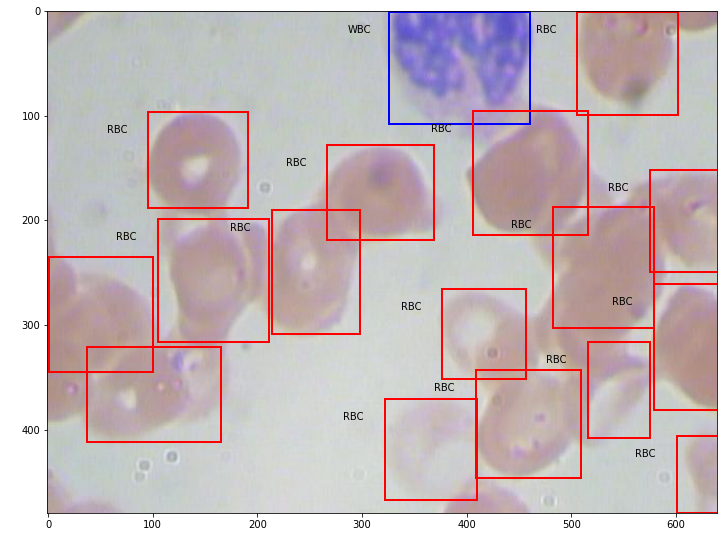

In [6]:
img_path = '/content/JPEGImages/BloodImage_024.jpg'

imgID = img_path.split('_')[-1].split('.')[0]
img_ann = BCCDdf.loc[BCCDdf['ID']==int(imgID)]
img_ann = img_ann.to_dict('records')
util.plot_annotation(img_path, img_ann)

## Exploratory data analysis

- Derive height and width of each bounding box  


In [7]:
# Derive height and width of each bounding box
BCCDdf['width'] = BCCDdf['xmax'] - BCCDdf['xmin']
BCCDdf['height'] = BCCDdf['ymax'] - BCCDdf['ymin']

- Normalize height and width with respect to image height and width  
 -  Comparing height and width of bounding boxes from different image size is not comparable. We need to normalize the height and width of each bounding box with respect to image height and width.

In [8]:
# store all image paths
imgpaths=glob.glob('/content/JPEGImages/*.jpg')

In [9]:
# Extract image size height and width from each image
imsize=[]
for img in imgpaths:
  im= Image.open(img)
  ID=int(img.split('_')[-1].split('.')[0])
  width, height = im.size
  imsize.append([ID,width,height])

In [10]:
imgsize = pd.DataFrame(imsize,columns=['ID','img_width','img_height'])

In [11]:
# add this info to original data frame BCCDdf
BCCD = BCCDdf.merge(right=imgsize, on='ID',how='left')

In [12]:
# Normalize height and width
BCCD['norm_height']= BCCD['height']/ BCCD['img_height']
BCCD['norm_width']= BCCD['width']/ BCCD['img_width']

- Plot normalized height and width of bounding boxes

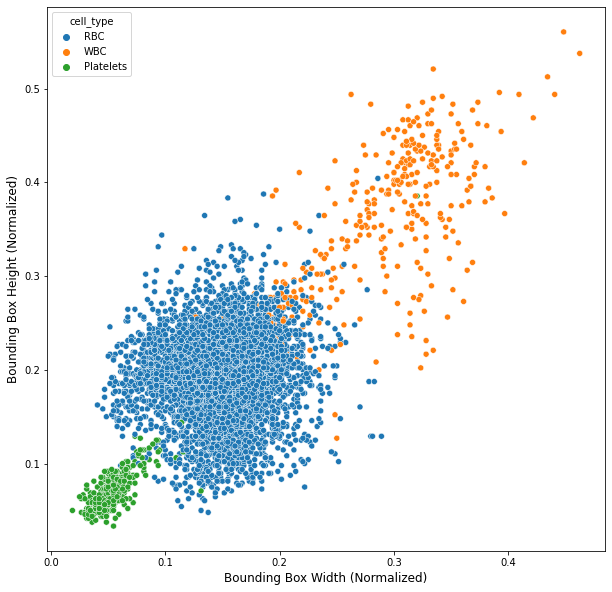

In [13]:
# Plot
plt.figure(figsize=(10,10))
sns.scatterplot(x='norm_width',y='norm_height', hue='cell_type', data=BCCD)
plt.xlabel('Bounding Box Width (Normalized)',size=12)
plt.ylabel('Bounding Box Height (Normalized)',size=12)
plt.show()

Observations:
- Platelets are smallest among all the cells
- RBC are medium sized
- WBCs are largest among all  


## Method -1 : K-Means clustering using a Eucledian distance measure
In YOLOV3, the anchor box size is calculated by using the k-means clustering method.we know the length and width of all marked bboxs, and the anchor box is a potential candidate box for predicting these bboxs. Therefore, the closer the length and width shape of the anchor box is to the real bbox, the better. 
k-means clustering method is commonly used, and its algorithm flow is as follows.  
- K points are randomly selected from the data set as the center of the initial clustering, and the center point is: $ C= { c_1, c_2, ...., c_k}$
- For each sample $x_i$ in the data set, the distance from them to each cluster center point is calculated. Which cluster center point has the smallest distance, it is alloted into the class of the corresponding cluster center.
- For each category i, the cluster center of that category is recalculated as:
$c_i = \frac{1}{|N_i|} \sum_{i \epsilon C_i} x_i$ (where $|N_i|$ is number of data points in i-th cluster $C_i$
- Above steps are recalculated until the cluster center does not changed

Since YOLOv3 configuration requires 9 anchor boxes, we'll calculate K-means with 9 clusters.

In [14]:
#Euclidean distance
def Euclidean_Distance(X, C):
  """
  Input:
  X : All observations
  C: All cluster centers
  Output:
  A list of Eucledean distance between each point with each of the cluster centers
  """
  all_distances = []
  for x,y in X:
    d_i =[] # Distances from point i
    for cx,cy in C:
      d = ((cx - x)**2 + (cy - y)**2)**0.5
      d_i.append(d)
    all_distances.append(d_i)
  
  return all_distances


In [15]:
# K means
def K_Means(X, k):
  """
  Input:
  X: All observations
  k: Number of clusters
  Output:
  A list of final cluster centers
  """
  if k < 1:
    print("Error: The number of cluster should be > 1")
  else:
    # Initialize k-centers
    ID = np.random.choice(a=np.arange(len(X)),size=k, replace=False)
    init_centers = [X[i] for i in ID]
    last_clusterid =np.zeros(len(X))
    while True:
      #Calculate distance of each point from cluster centers
      distances = Euclidean_Distance(X, init_centers)
      # Get cluster index for nearest cluster center for each point
      nearset_clusterid = np.argmin(distances, axis=1)
      # If cluster allocation for each point does not chnage exit
      if (last_clusterid == nearset_clusterid).all():
        break
      for i in range(k):
        # Re initialize cluster centers as mean of points assigned to the same cluster
        init_centers[i]= np.mean([X[id] for id,value in enumerate(nearset_clusterid) if value==i],axis=0)
      
      last_clusterid = nearset_clusterid

  return init_centers, last_clusterid

### Evaluate K-means with 9 centroids

In [16]:
# Collect normalized height and width
df= BCCD[['norm_width', 'norm_height']]
# Convert to list of [width, height]
allobs = df.values.tolist()

In [17]:
centers_Kmeans, bbox_labels = K_Means(allobs,9)

Evaluate anchor proposals for a 416 x 416 image input

In [18]:
centers_416 = [[int(416*centers_Kmeans[i][0]), int(416*centers_Kmeans[i][1])] for i in range(9)]
anchors_416 = pd.DataFrame(centers_416, columns=['width','height'])
anchors_416.sort_values(by=['width'])

,width,height
5,21,28
4,37,76
3,50,98
6,59,74
8,62,49
7,66,88
0,78,109
1,81,75
2,133,166


Plot proposed anchor centroids

In [19]:
BCCD['Cluster_label']= bbox_labels

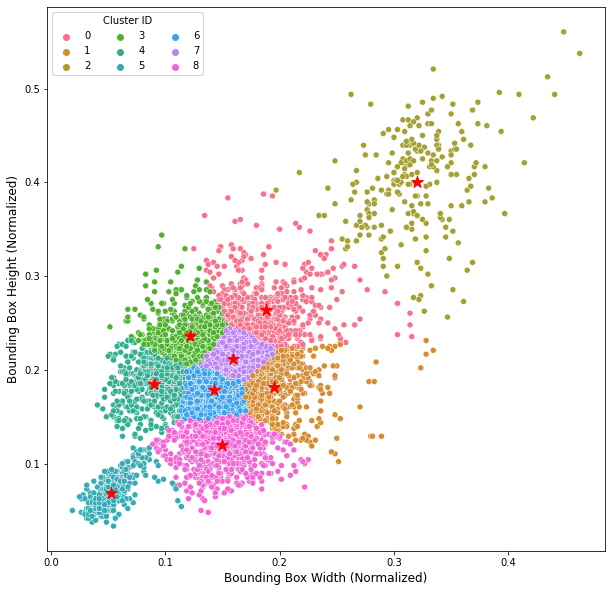

In [20]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='norm_width',y='norm_height', hue='Cluster_label', data=BCCD, palette=sns.color_palette("husl",9))
plt.legend(title='Cluster ID', loc='upper left', ncol=3)
plt.scatter(x=[centers_Kmeans[i][0] for i in range(9)], y=[centers_Kmeans[i][1] for i in range(9)], marker='*',s=150,c='r')
plt.xlabel('Bounding Box Width (Normalized)',size=12)
plt.ylabel('Bounding Box Height (Normalized)',size=12)

plt.show()

For few clusters, the cluster boundaries seems to be overlapping each other

In [21]:
BCCD = BCCD.drop(['Cluster_label'],axis=1)

## Method -2 : K-Means ++ clustering using a Eucledian distance measure

K-means clustering is sensitive to initial choice of centroids. K-Means ++ provides a better initialization of centriods. That allows the algorithm to be less sensitive to initial choice.  
1. Randomly select the first centroid from the data points.
2. For each data point compute its distance from the nearest, previously chosen centroid.
3. Select the next centroid from the data points such that the probability of choosing a point as centroid is directly proportional to its distance from the nearest, previously chosen centroid. (i.e. the point having maximum distance from the nearest centroid is most likely to be selected next as a centroid)
4. Repeat steps 2 and 3 until k centroids have been sampled

In [22]:
def initial_center(X,k):
  """
  Input
  X: All observations
  k: Number of clusters / cluster centroids
  """
  init_cluster= np.empty((k,2))
  init_cluster[:] = 0
  init_cluster[0]= X[np.random.choice(np.arange(len(X)),1)[0]]
  for i in range(k-1):
    d = Euclidean_Distance(X,init_cluster)
    # Find the distance from nearest centroid of each point
    nearest_dist = np.min(d, axis=1)
    # Find point with maximum distance from nearest centroids as next centriod 
    new_center = X[np.argmax(nearest_dist)]
    init_cluster[i+1] = np.array(new_center)
  return init_cluster

  

### Determine initial clusters

In [23]:
temp=initial_center(allobs,9)

Initial cluster centroid position with respect to other data points

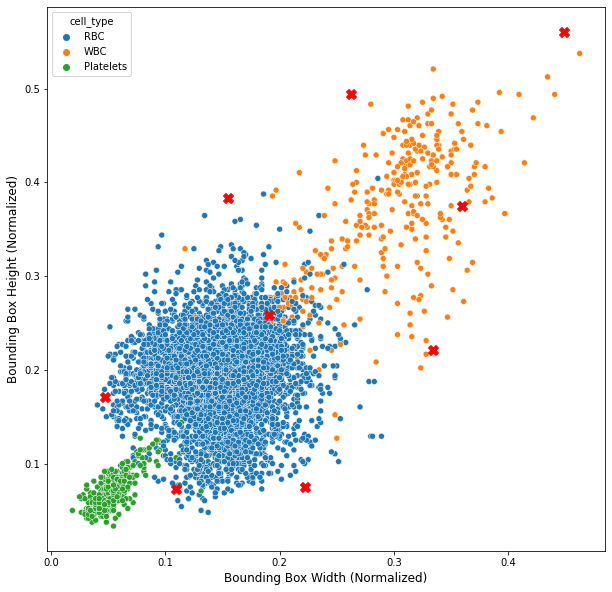

In [24]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='norm_width',y='norm_height', hue='cell_type', data=BCCD)
plt.scatter(x=[temp[i][0] for i in range(9)], y=[temp[i][1] for i in range(9)], label="initial centroids", marker='X',s=100,c='r')
plt.xlabel('Bounding Box Width (Normalized)',size=12)
plt.ylabel('Bounding Box Height (Normalized)',size=12)
plt.show()

### Find final cluster centriods by K-Means ++

In [50]:
# K-means ++ algorithm
def K_Means_Plus_Plus(X,k):
  """
  Input:
  X: All observations
  k: Number of clusters
  Output:
  A list of final cluster centers
  """
  if k < 1:
    print("Error: The number of cluster should be > 1")
  else:
    # Initialize using K_means ++ algorithm mentioned above
    init_centers= initial_center(X,k)
    # Rest is similar to K means
    last_clusterid =np.zeros(len(X))
    while True:
      #Calculate distance of each point from cluster centers
      distances = Euclidean_Distance(X, init_centers)
      # Get cluster index for nearest cluster center for each point
      nearset_clusterid = np.argmin(distances, axis=1)
      # If cluster allocation for each point does not chnage exit
      if (last_clusterid == nearset_clusterid).all():
        break
      for i in range(k):
        # Re initialize cluster centers as mean of points assigned to the same cluster
        init_centers[i]= np.mean([X[id] for id,value in enumerate(nearset_clusterid) if value==i],axis=0)
      
      last_clusterid = nearset_clusterid

  return init_centers, last_clusterid

In [51]:
centers_Kmeans_Plus, bbox_labels= K_Means_Plus_Plus(allobs,9)

Cluster centriods based on K means ++ algorithm with 416 x 416 pixel image

In [52]:
centers_416 = [[int(416*centers_Kmeans_Plus[i][0]), int(416*centers_Kmeans_Plus[i][1])] for i in range(9)]
anchors_416 = pd.DataFrame(centers_416, columns=['width','height'])
anchors_416.sort_values(by=['width'])

,width,height
0,22,28
7,38,82
3,60,88
8,60,71
5,64,49
4,70,107
2,77,82
6,115,134
1,137,177


In [53]:
BCCD['Cluster_label']= bbox_labels

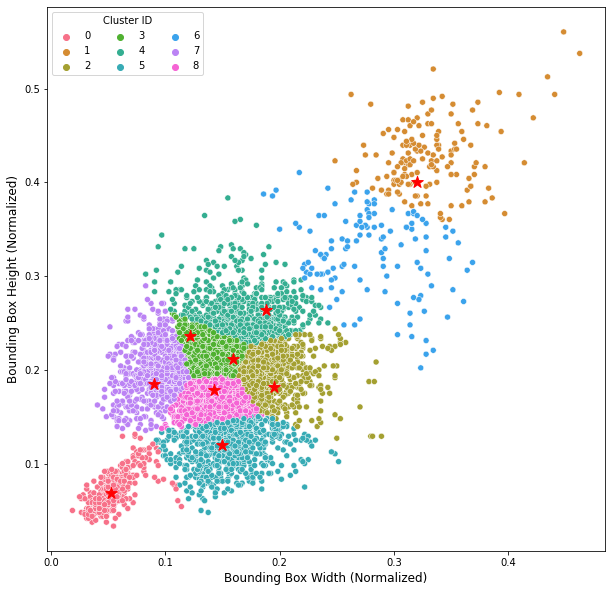

In [54]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='norm_width',y='norm_height', hue='Cluster_label', data=BCCD, palette=sns.color_palette("husl",9))
plt.legend(title='Cluster ID', loc='upper left', ncol=3)
plt.scatter(x=[centers_Kmeans[i][0] for i in range(9)], y=[centers_Kmeans[i][1] for i in range(9)], marker='*',s=150,c='r')
plt.xlabel('Bounding Box Width (Normalized)',size=12)
plt.ylabel('Bounding Box Height (Normalized)',size=12)

plt.show()

This even got worse. Apparently there are two centroids within a cluster. This might happen due to the metric mean used for cluster center calculation

In [30]:
BCCD = BCCD.drop(['Cluster_label'], axis=1)

Note that : K means ++ allows seperate center for platelets and two proposals for WBC region

## K Means with IoU as distance metric

In this section, we'll use inter section over union (IoU) between cluster center and point as distance metric on stead of Euclidean distance.

In [31]:
def IoU (bbox, clusters):
  """
  Input
  bbox: Bounding box co-ordinates (must include width and height)
  clusters: cluster centers of shape (k,2), k is number of clusters
  Output
  An array of IoUs between a bounding box and an anchor box 
  with pre specified height and width as co-ordinates of the cluster center
  """
  int_w = np.minimum(clusters[:,0], bbox[0])
  int_h = np.minimum(clusters [:,1],bbox[1])
  # Area of intersection
  int_area = int_w * int_h
  #Area of bounding box
  bbox_area = bbox[0] * bbox[1]
  # Area of anchor box
  anchor_area = clusters[:,0] * clusters[:,1]

  IoU_score = int_area / (bbox_area + anchor_area - int_area)

  return IoU_score


Now, rebuild the K-means algorithm with with IoU as distance measure

In [32]:
# K means
def K_Means_IoU(X, k):
  """
  Input:
  X: All observations
  k: Number of clusters
  Output:
  A list of final cluster centers
  """
  if k < 1:
    print("Error: The number of cluster should be > 1")
  else:
    # Initialize k-centers
    ID = np.random.choice(a=np.arange(len(X)),size=k, replace=False)
    init_centers = np.array([np.array(X[i]) for i in ID])
    last_clusterid =np.zeros(len(X))
    distances=np.zeros(shape=(len(X),k))
    while True:
      #Calculate distance of each point from cluster centers
      for i in range(len(X)):
        distances[i,]= 1-IoU(X[i],init_centers)
      # Get cluster index for nearest cluster center for each point
      nearset_clusterid = np.argmin(distances, axis=1)
      # If cluster allocation for each point does not chnage exit
      if (last_clusterid == nearset_clusterid).all():
        break
      for i in range(k):
        # Re initialize cluster centers as mean of points assigned to the same cluster
        init_centers[i]= np.mean([X[id] for id,value in enumerate(nearset_clusterid) if value==i],axis=0)
      
      last_clusterid = nearset_clusterid

  return init_centers, last_clusterid

In [33]:
centers_Kmeans_IoU, bbox_labels=K_Means_IoU(allobs,9)

Cluster centriods based on K means algorithm with 416 x 416 pixel image with a IoU diatance measure

In [34]:
centers_416 = [[int(416*centers_Kmeans_IoU[i][0]), int(416*centers_Kmeans_IoU[i][1])] for i in range(9)]
anchors_416 = pd.DataFrame(centers_416, columns=['width','height'])
anchors_416.sort_values(by=['width'])

,width,height
7,20,27
5,33,77
1,51,93
8,56,72
2,61,45
4,66,85
3,75,68
6,76,104
0,130,161


In [35]:
BCCD['Cluster_label']= bbox_labels

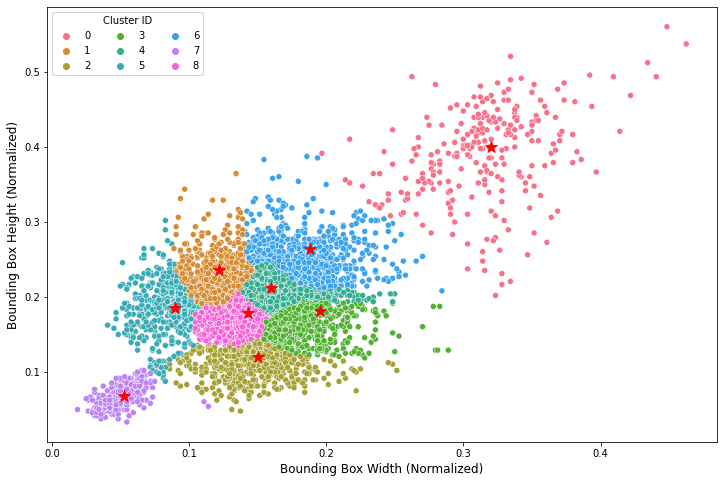

In [36]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='norm_width',y='norm_height', hue='Cluster_label', data=BCCD, palette=sns.color_palette("husl",9))
plt.legend(title='Cluster ID', loc='upper left', ncol=3)
plt.scatter(x=[centers_Kmeans[i][0] for i in range(9)], y=[centers_Kmeans[i][1] for i in range(9)], marker='*',s=150,c='r')
plt.xlabel('Bounding Box Width (Normalized)',size=12)
plt.ylabel('Bounding Box Height (Normalized)',size=12)

plt.show()

Mostly accurate. Still few cluster boundaries can be improved.

## K-Means ++ with IoU as distance metric
We rebuild the K-means ++ algorithm with IoU as distance metric.

In [37]:
def initial_center_IoU(X,k):
  """
  Input
  X: All observations
  k: Number of clusters / cluster centroids
  """
  init_cluster= np.empty((k,2))
  init_cluster[:] = 0
  init_cluster[0]= X[np.random.choice(np.arange(len(X)),1)[0]]
  distances=np.zeros(shape=(len(X),k))
  for i in range(k-1):
    #Calculate distance of each point from cluster centers
    for j in range(len(X)):
      distances[j,]= 1-IoU(X[j],init_cluster)
    # Find the distance from nearest centroid of each point
    nearest_dist = np.min(distances, axis=1)
    # Find point with maximum distance from nearest centroids as next centriod 
    new_center = X[np.argmax(nearest_dist)]
    init_cluster[i+1] = np.array(new_center)
  return init_cluster

### Determine initial choice of clusters

In [38]:
temp=initial_center_IoU(allobs,9)

Plot initial choice of cluster against all the points

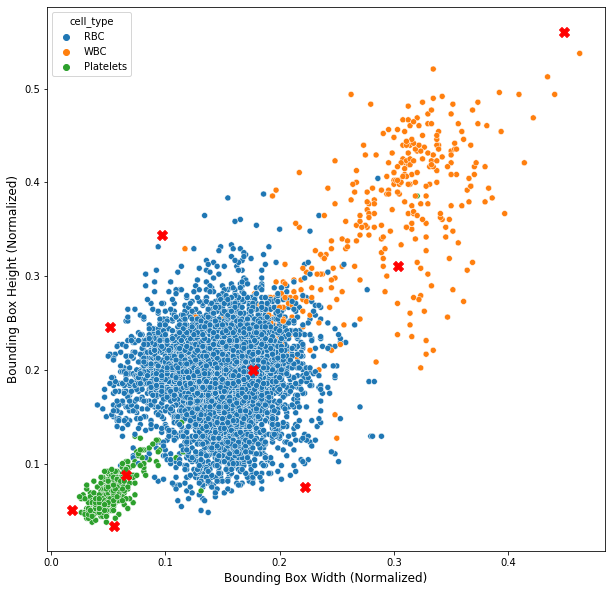

In [39]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='norm_width',y='norm_height', hue='cell_type', data=BCCD)
plt.scatter(x=[temp[i][0] for i in range(9)], y=[temp[i][1] for i in range(9)], label="initial centroids", marker='X',s=100,c='r')
plt.xlabel('Bounding Box Width (Normalized)',size=12)
plt.ylabel('Bounding Box Height (Normalized)',size=12)
plt.show()

Tracks almost all furthest points

### Find final choice of clusters by K means ++ algorith with IoU distance metric

In [40]:
# K-means ++ algorithm
def K_Means_IoU_Plus_Plus(X,k):
  """
  Input:
  X: All observations
  k: Number of clusters
  Output:
  A list of final cluster centers
  """
  if k < 1:
    print("Error: The number of cluster should be > 1")
  else:
    # Initialize using K_means ++ algorithm mentioned above
    init_centers= initial_center_IoU(X,k)
    # Rest is similar to K means
    last_clusterid =np.zeros(len(X))
    distances=np.zeros(shape=(len(X),k))
    while True:
      #Calculate distance of each point from cluster centers
      for j in range(len(X)):
        distances[j,]= 1-IoU(X[j],init_centers)
      # Get cluster index for nearest cluster center for each point
      nearset_clusterid = np.argmin(distances, axis=1)
      # If cluster allocation for each point does not chnage exit
      if (last_clusterid == nearset_clusterid).all():
        break
      for i in range(k):
        # Re initialize cluster centers as mean of points assigned to the same cluster
        init_centers[i]= np.mean([X[id] for id,value in enumerate(nearset_clusterid) if value==i],axis=0)
      
      last_clusterid = nearset_clusterid

  return init_centers, last_clusterid

In [41]:
centers_Kmeans_IoU_Plus, bbox_labels= K_Means_IoU_Plus_Plus(allobs,9)

Calculate agains a 416 x 416 pixel input image

In [42]:
centers_416 = [[int(416*centers_Kmeans_IoU_Plus[i][0]), int(416*centers_Kmeans_IoU_Plus[i][1])] for i in range(9)]
anchors_416 = pd.DataFrame(centers_416, columns=['width','height'])
anchors_416.sort_values(by=['width'])

,width,height
1,20,27
7,33,76
8,48,92
5,57,73
3,61,46
0,65,90
4,75,72
6,81,104
2,132,163


In [43]:
BCCD['Cluster_label']= bbox_labels

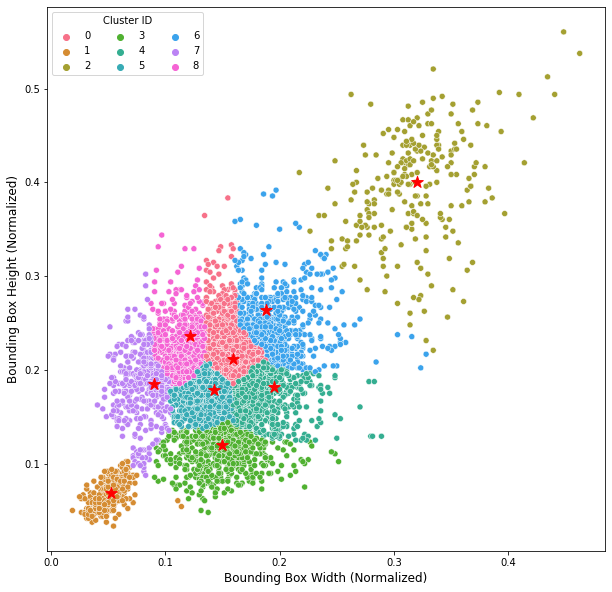

In [44]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='norm_width',y='norm_height', hue='Cluster_label', data=BCCD, palette=sns.color_palette("husl",9))
plt.legend(title='Cluster ID', loc='upper left', ncol=3)
plt.scatter(x=[centers_Kmeans[i][0] for i in range(9)], y=[centers_Kmeans[i][1] for i in range(9)], marker='*',s=150,c='r')
plt.xlabel('Bounding Box Width (Normalized)',size=12)
plt.ylabel('Bounding Box Height (Normalized)',size=12)

plt.show()

Most appropiate clustering:
- cluster boundaries are mostly non-overlapping
- Cluster centers are also distant from each other
- Cluster centers are well in between the central location of each cluster